### open csv and inspect data

0 load old file without time cutoff point; create df_network as a copy of df_network which only has channel_name, links, channel_category, and datetime; set media = movement

1 when first official party chat? 

2 visualise party messages over time

3 segment dataset to see how it evolves over time and see how centrality and degree of party chats change
    

4 create set with and without party


### step 0: create df_network and edgelist

In [13]:
import pandas as pd
df = pd.read_csv("output_final_t5.csv")

/tmp/ipykernel_4538/3404650627.py:2: DtypeWarning: Columns (9,10,11,12,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("output_final_t5.csv")


In [14]:
duplicates = df.duplicated(subset='link_to_message', keep=False)

# Counting the number of duplicates
number_of_duplicates = duplicates.sum()

# Printing the number of duplicates
print(f"Number of duplicate entries in 'link_to_message': {number_of_duplicates}")
df = df.drop_duplicates(subset= "link_to_message", keep='first')
duplicates = df.duplicated(subset='link_to_message', keep=False)

# Counting the number of duplicates
number_of_duplicates = duplicates.sum()

# Printing the number of duplicates
print(f"Number of duplicate entries in 'link_to_message': {number_of_duplicates}")

Number of duplicate entries in 'link_to_message': 306047
Number of duplicate entries in 'link_to_message': 0


In [15]:
na_count = df['text'].isna().sum()
print(f"Number of rows with NA in 'text' column: {na_count}")

# Remove rows where 'text' is NA
df = df.dropna(subset=['text']).copy()

# Verify removal
print(f"Number of rows after removing NAs: {len(df)}")

Number of rows with NA in 'text' column: 84637
Number of rows after removing NAs: 1508159


In [31]:
df['channel_category'] = 0

# Function to categorize channel based on 'channel_name'
def categorize_channel(channel_name):
    channel_name_lower = channel_name.lower()
    if 'basis' in channel_name_lower:
        return 'party'
    return 'movement'  # Return 'movement'

# Apply the categorization function to the 'channel_name' column
df['channel_category'] = df['channel_name'].apply(categorize_channel)

# Display the DataFrame to verify the new 'channel_category' column
print(df)
df_network = df[['channel_name', 'links', 'channel_category', 'datetime']].copy()
df_network['datetime'] = pd.to_datetime(df_network['datetime'])

            channel_name                   link_to_message  \
0        die_basis_funkt  https://t.me/s/die_basis_funkt/3   
1        die_basis_funkt  https://t.me/s/die_basis_funkt/4   
3        die_basis_funkt  https://t.me/s/die_basis_funkt/6   
4        die_basis_funkt  https://t.me/s/die_basis_funkt/8   
5        die_basis_funkt  https://t.me/s/die_basis_funkt/9   
...                  ...                               ...   
1768831           bustek         https://t.me/s/bustek/149   
1768832           bustek         https://t.me/s/bustek/150   
1768833           bustek         https://t.me/s/bustek/151   
1768834           bustek         https://t.me/s/bustek/152   
1768835           bustek         https://t.me/s/bustek/153   

         could_be_displayed            user                     user_link  \
0                      True  dieBasis funkt  https://t.me/die_basis_funkt   
1                      True  dieBasis funkt  https://t.me/die_basis_funkt   
3                     Fa

In [33]:
df_network['channel_category'] = df_network['channel_category'].replace('media', 'movement')
df_network['channel_category'] = df_network['channel_category'].replace('0', 'movement')
df_network['channel_category'] = df_network['channel_category'].replace(0, 'movement')

In [34]:
print(df_network['channel_category'].unique())

['party' 'movement']


In [35]:
import re
def extract_valid_telegram_username(link_text):
    # Ensure input is a string
    if not isinstance(link_text, str):
        return None
    # Define the pattern for extracting Telegram usernames
    telegram_pattern = re.compile(r'(?:https?://)?t\.me/([\w\d_-]+)')
    # Search for all occurrences of the pattern
    matches = telegram_pattern.findall(link_text)
    # Filter out any non-Telegram links or invalid entries
    valid_usernames = [match for match in matches if not any(ext in match for ext in ['http', 'https', '|'])]
    # Return the first valid Telegram username, if available
    return valid_usernames[0] if valid_usernames else None

# Apply the refined function to extract valid Telegram usernames
df_network['links'] = df_network['links'].apply(extract_valid_telegram_username)
df_network['links'] = df_network['links'].str.lower()

# Drop rows without a valid Telegram username
df_network = df_network.dropna(subset=['links'])
df_network = df_network.dropna(subset=['channel_name'])
df_network = df_network.dropna(subset=['channel_category'])

contains_floats = df_network['links'].apply(lambda x: isinstance(x, float)).any()

if contains_floats:
    print("The column contains float values.")
    df_network = df_network[~df_network['links'].apply(lambda x: isinstance(x, float))]
else:
    print("No float values in 'links'.")

# create edgelist for copy
edgelist = df_network.copy()
edgelist['source'] = edgelist['channel_name'].str.lower()
edgelist['target'] = edgelist['links'].str.lower()
edgelist['channel_category'] = edgelist['channel_category'].str.lower()

edgelist = edgelist.drop('channel_name', axis=1)
edgelist = edgelist.drop('links', axis=1)
# Display the first few rows of edgelist to verify
print(edgelist.head())
len(edgelist)

No float values in 'links'.
   channel_category                  datetime           source  \
0             party 2020-07-05 23:50:42+00:00  die_basis_funkt   
6             party 2020-07-09 19:48:27+00:00  die_basis_funkt   
7             party 2020-07-15 12:26:54+00:00  die_basis_funkt   
10            party 2020-07-17 15:59:52+00:00  die_basis_funkt   
15            party 2020-07-23 18:30:27+00:00  die_basis_funkt   

                      target  
0            die_basis_funkt  
6       henning_basis_berlin  
7           diebasisnrwfunkt  
10  diebasis_infoszuumfragen  
15                  diebasis  


867290

### step 1: visualisation

Earliest mention of 'basis': 2020-06-26 07:29:18+00:00


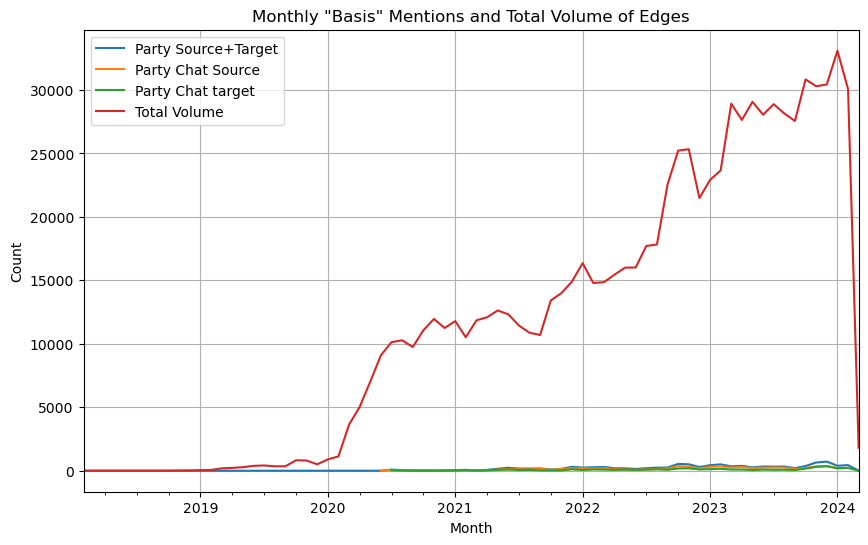

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Assuming 'df_network' is your DataFrame
# Convert 'datetime' to datetime format (if it's not already)
edgelist['datetime'] = pd.to_datetime(edgelist['datetime'])

# Set 'datetime' as the DataFrame index
if 'datetime' in edgelist.columns:
    edgelist['datetime'] = pd.to_datetime(edgelist['datetime'])
    edgelist.set_index('datetime', inplace=True)
elif not isinstance(edgelist.index, pd.DatetimeIndex):
    # If 'datetime' is not a column and the index is not a DatetimeIndex, there might be an issue
    raise ValueError("The DataFrame does not have a 'datetime' column or datetime index.")


# Resample by month and count occurrences
# a) Sum of 'basis' in source and target
edgelist['basis_in_source'] = edgelist.apply(lambda x: 'basis' in x['source'] if isinstance(x['source'], str) else False, axis=1)
edgelist['basis_in_target'] = edgelist.apply(lambda x: 'basis' in x['target'] if isinstance(x['target'], str) else False, axis=1)
edgelist_monthly_basis = edgelist.resample('ME').sum()

# b) Only in source
edgelist_monthly_source = edgelist[edgelist['channel_category'] == 'party'].resample('ME').count()

# c) Only in target - assuming direct text match, adjust for regex if needed
edgelist_monthly_target = edgelist[edgelist['basis_in_target']].resample('ME').count()

# Total volume of edges per month
edgelist_monthly_total = edgelist.resample('ME').count()

# Combine into a single DataFrame
edgelist_combined = pd.DataFrame({
    'Party Source+Target': edgelist_monthly_basis['basis_in_source'] + edgelist_monthly_basis['basis_in_target'],
    'Party Chat Source': edgelist_monthly_source['source'],
    'Party Chat target': edgelist_monthly_target['target'],
    'Total Volume': edgelist_monthly_total['source']  # or any column that exists for every row
})

# Plotting
plt.figure(figsize=(10, 6))
edgelist_combined.plot(kind='line', ax=plt.gca())
plt.title('Monthly "Basis" Mentions and Total Volume of Edges')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)
plt.legend()

# Print the earliest mention of "basis"
earliest_basis = edgelist[edgelist['basis_in_source'] | edgelist['basis_in_target']].index.min()
print(f"Earliest mention of 'basis': {earliest_basis}")

plt.show()

Earliest mention of 'basis': 2020-06-26 07:29:18+00:00


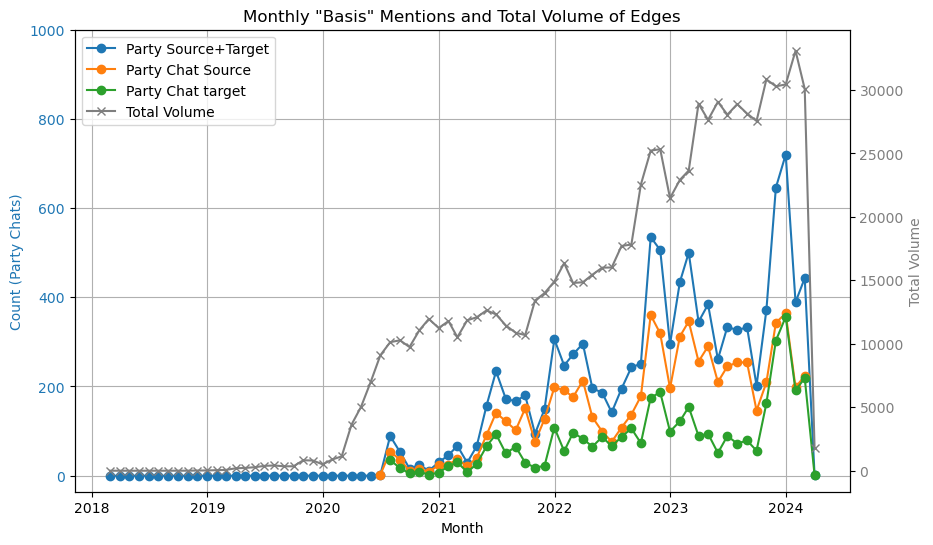

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import re


# Plotting for left axis
fig, ax = plt.subplots(figsize=(10, 6))
for column in ['Party Source+Target', 'Party Chat Source', 'Party Chat target']:
    ax.plot(edgelist_combined.index, edgelist_combined[column], marker='o', label=column)

ax.set_title('Monthly "Basis" Mentions and Total Volume of Edges')
ax.set_xlabel('Month')
ax.set_ylabel('Count (Party Chats)', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.grid(True)
ax.set_ylim(None, 1000)  # Automatically adjust the lower limit, set the upper limit to 1000

#second x axis
ax2 = ax.twinx()
ax2.plot(edgelist_combined.index, edgelist_combined['Total Volume'], color='tab:grey', marker='x', label='Total Volume')
ax2.set_ylabel('Total Volume', color='tab:grey')  
ax2.tick_params(axis='y', labelcolor='tab:grey')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

earliest_basis = edgelist[edgelist['basis_in_source'] | edgelist['basis_in_target']].index.min()
print(f"Earliest mention of 'basis': {earliest_basis}")

plt.show()

### step 2: inspect splitting purposefulness

In [40]:
import pandas as pd

# Ensure datetime is in the correct format and set as index

# Define the split point
split_point = pd.Timestamp('2020-06-26 07:29:18+00:00', tz='UTC')

# Split data into before and after the split point
before = edgelist[edgelist.index < split_point]
after = edgelist[edgelist.index >= split_point]

# Count edges in each period
edges_before = before.shape[0]
edges_after = after.shape[0]

# Identify unique nodes
nodes_before = pd.unique(before[['source', 'target']].values.ravel('K'))
nodes_after = pd.unique(after[['source', 'target']].values.ravel('K'))

# Count unique nodes
unique_nodes_before = len(nodes_before)
unique_nodes_after = len(nodes_after)

# Calculate time periods lengths in days
period_before_days = (split_point - edgelist.index.min()).days
period_after_days = (edgelist.index.max() - split_point).days

# Weight counts by period length
edges_before_weighted = edges_before / period_before_days
edges_after_weighted = edges_after / period_after_days
nodes_before_weighted = unique_nodes_before / period_before_days
nodes_after_weighted = unique_nodes_after / period_after_days

# Weight counts by period length and print with explanations
print(f"Edges before 2020-06-26: {edges_before} (weighted by time: {edges_before_weighted:.2f} edges/day)")
print(f"Edges after 2020-06-26: {edges_after} (weighted by time: {edges_after_weighted:.2f} edges/day)")
print(f"Unique nodes before 2020-06-26: {unique_nodes_before} (weighted by time: {nodes_before_weighted:.2f} nodes/day)")
print(f"Unique nodes after 2020-06-26: {unique_nodes_after} (weighted by time: {nodes_after_weighted:.2f} nodes/day)")


Edges before 2020-06-26: 29842 (weighted by time: 34.30 edges/day)
Edges after 2020-06-26: 837448 (weighted by time: 622.18 edges/day)
Unique nodes before 2020-06-26: 1074 (weighted by time: 1.23 nodes/day)
Unique nodes after 2020-06-26: 11364 (weighted by time: 8.44 nodes/day)


### step 3: segment network based on months and run metrics, identify trends
Dynamic Network Analysis: For each time segment (months), calculate network metrics (centrality, density, modularity) and observe trends. For example, an increasing trend in the centrality of party nodes or changes in modularity could indicate the party's growing influence or the formation of new clusters.

##### attempt to compare to normal growth

In [43]:
import pandas as pd
import networkx as nx
from datetime import datetime
monthly_edges = edgelist.groupby(pd.Grouper(freq='ME'))

In [44]:
!pip install python-louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=600918b238ea5bb7e3ad97d6a67f404db9d197bca15fd1d7b2f452005cd633f2
  Stored in directory: /home/onyxia/.cache/pip/wheels/11/c1/e7/f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


In [89]:
###define functions
import pandas as pd
import networkx as nx
import numpy as np
import community as community_louvain
import matplotlib.pyplot as plt

# Assuming 'edgelist' DataFrame is already defined and 'monthly_edges' is created from it
# edgelist['datetime'] = pd.to_datetime(edgelist['datetime'])
# monthly_edges = edgelist.groupby(pd.Grouper(key='datetime', freq='M'))

n_nodes_edges = []

# Calculate n_nodes and n_edges for each month
for name, group in monthly_edges:
    unique_nodes = pd.unique(group[['source', 'target']].values.ravel('K'))
    n_nodes = len(unique_nodes)
    n_edges = group.shape[0]
    n_nodes_edges.append((name, n_nodes, n_edges))

n_nodes_edges_filtered = [(name, n_nodes, n_edges) for name, n_nodes, n_edges in n_nodes_edges if n_edges >= 1000]
if not n_nodes_edges_filtered[-1][2]:  # Check if the last entry meets your criteria
    n_nodes_edges_filtered.pop()

def generate_random_network(n_nodes, n_edges):
    G_random = nx.Graph()
    G_random.add_nodes_from(range(n_nodes))
    
    while G_random.number_of_edges() < n_edges:
        node_pair = np.random.choice(n_nodes, 2, replace=False)
        if not G_random.has_edge(*node_pair):
            G_random.add_edge(*node_pair)
    
    return G_random

def calculate_average_degree_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    average_centrality = sum(degree_centrality.values()) / len(degree_centrality)
    return average_centrality

In [92]:
import pandas as pd
import networkx as nx
# Assuming generate_random_network and calculate_average_degree_centrality are defined
metrics_list = []

# Assuming n_nodes_edges_filtered, monthly_edges_list, and monthly_values are already defined
for ((name, group), edge_count), (_, n_nodes, n_edges) in zip(zip(monthly_edges_list, monthly_values), n_nodes_edges_filtered):
    if edge_count >= 1000:  # Apply the threshold
        # Generate a random network with the same n_nodes and n_edges
        G_random = generate_random_network(n_nodes, n_edges)
        
        # Calculate the average degree centrality of the random network
        avg_degree_centrality_random = calculate_average_degree_centrality(G_random)
        
        # Generate the actual network graph from the group
        G_actual = nx.from_pandas_edgelist(group, 'source', 'target')
        
        # Calculate average degree centrality for the actual network
        avg_degree_centrality_actual = calculate_average_degree_centrality(G_actual)
        
        # Calculate density for the actual network
        density = nx.density(G_actual)
        
        # Extract centrality for specified party nodes
        degree_centrality = nx.degree_centrality(G_actual)
        party_nodes = ["agfriedendiebasis", "die_basis_funkt", "diebasisnrwfunkt"]
        party_centrality = {node: degree_centrality.get(node, None) for node in party_nodes}
        
        # Store metrics, including both random and actual network centrality measures
        metrics_list.append({
            'month': name.strftime('%Y-%m'),
            'density': density,
            'avg_degree_centrality_random': avg_degree_centrality_random,
            'avg_degree_centrality_actual': avg_degree_centrality_actual,
            'party_centrality': party_centrality  # Consider how you want to represent this data
        })

# Convert metrics list to DataFrame for analysis
metrics_df = pd.DataFrame(metrics_list)


KeyError: 'avg_degree_centrality_real'

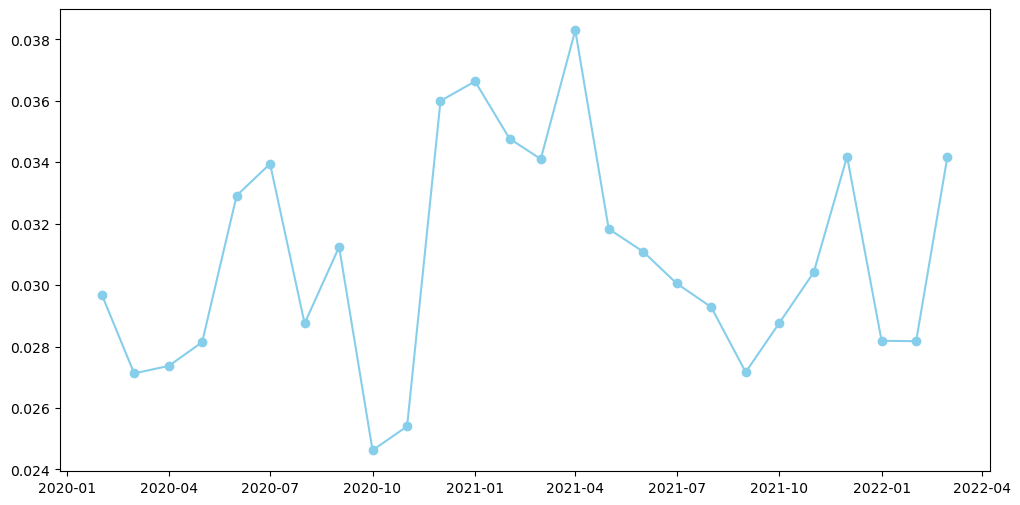

In [93]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming metrics_df is your DataFrame and it's already populated with the necessary data

# Ensure 'month' is in datetime format for plotting
metrics_df['month'] = pd.to_datetime(metrics_df['month'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot average degree centrality for random networks
plt.plot(metrics_df['month'], metrics_df['avg_degree_centrality_random'], label='Random Network', marker='o', linestyle='-', color='skyblue')

# Plot average degree centrality for actual networks
plt.plot(metrics_df['month'], metrics_df['avg_degree_centrality_real'], label='Actual Network', marker='x', linestyle='-', color='darkblue')

plt.title('Average Degree Centrality Over Time')
plt.xlabel('Month')
plt.ylabel('Average Degree Centrality')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [ ]:
print("hi")

### forgot what this is below its a bit adjusted, perhaps for average growth

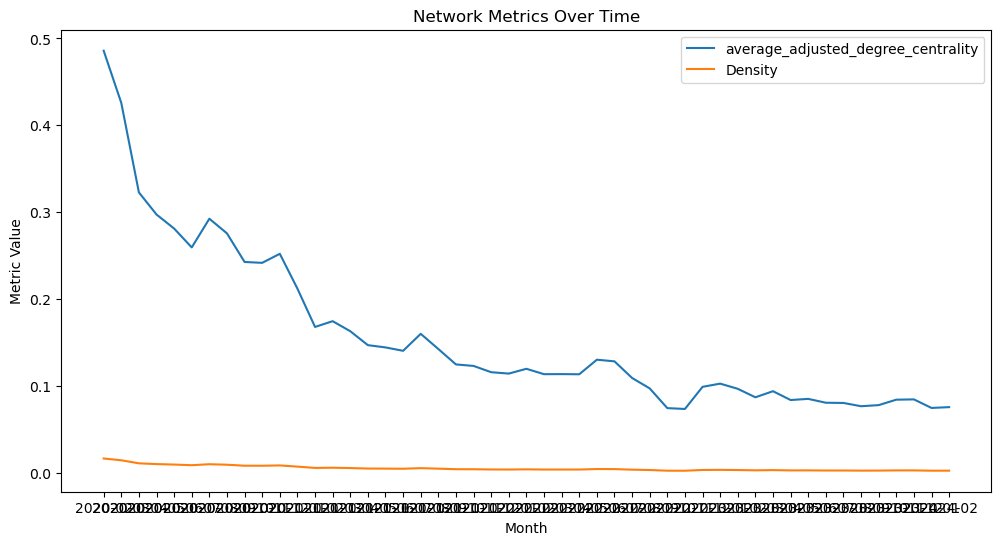

In [86]:
import matplotlib.pyplot as plt

# Plotting trends
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['month'], metrics_df['average_adjusted_degree_centrality'], label='average_adjusted_degree_centrality')
plt.plot(metrics_df['month'], metrics_df['density'], label='Density')
# plt.plot(metrics_df['month'], metrics_df['modularity'], label='Modularity')  # Uncomment when modularity is calculated
plt.xlabel('Month')
plt.ylabel('Metric Value')
plt.title('Network Metrics Over Time')
plt.legend()
plt.show()

##### here is the actual without adjustment

In [85]:
import networkx as nx

metrics_list = []

for (name, group), edge_count in zip(monthly_edges_list, monthly_values):
    if edge_count >= 1000:  # Apply the threshold
        G = nx.from_pandas_edgelist(group, 'source', 'target')
        
        # Calculate density
        density = nx.density(G)
        
        # Calculate degree centrality and normalized degree centrality
        degree_centrality = nx.degree_centrality(G)
        
        adjusted_degree_centrality = {node: centrality * growth_factor for node, centrality in degree_centrality.items()}
        
        # Calculate average adjusted degree centrality
        average_adjusted_degree_centrality = sum(adjusted_degree_centrality.values()) / len(adjusted_degree_centrality) if adjusted_degree_centrality else None
        
        # Extract centrality for specified party nodes
        party_nodes = ["agfriedendiebasis", "die_basis_funkt", "diebasisnrwfunkt"]
        party_centrality = {node: degree_centrality.get(node, None) for node in party_nodes}
        
        # Store metrics
        metrics_list.append({
            'month': name.strftime('%Y-%m'),
            'density': density,
            'modularity': modularity,
            'party_centrality': party_centrality,
            'average_adjusted_degree_centrality': average_adjusted_degree_centrality,
        })

# Convert metrics list to DataFrame for analysis
metrics_df = pd.DataFrame(metrics_list)

print("Analysis Complete")


Adjusted Centrality Analysis Complete
Analysis Complete


In [ ]:
import matplotlib.pyplot as plt

# Plotting trends
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['month'], metrics_df['average_adjusted_degree_centrality'], label='average_adjusted_degree_centrality')
plt.plot(metrics_df['month'], metrics_df['density'], label='Density')
# plt.plot(metrics_df['month'], metrics_df['modularity'], label='Modularity')  # Uncomment when modularity is calculated
plt.xlabel('Month')
plt.ylabel('Metric Value')
plt.title('Network Metrics Over Time')
plt.legend()
plt.show()

/tmp/ipykernel_4538/1669632718.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2018-02-28', periods=len(monthly_values), freq='M')


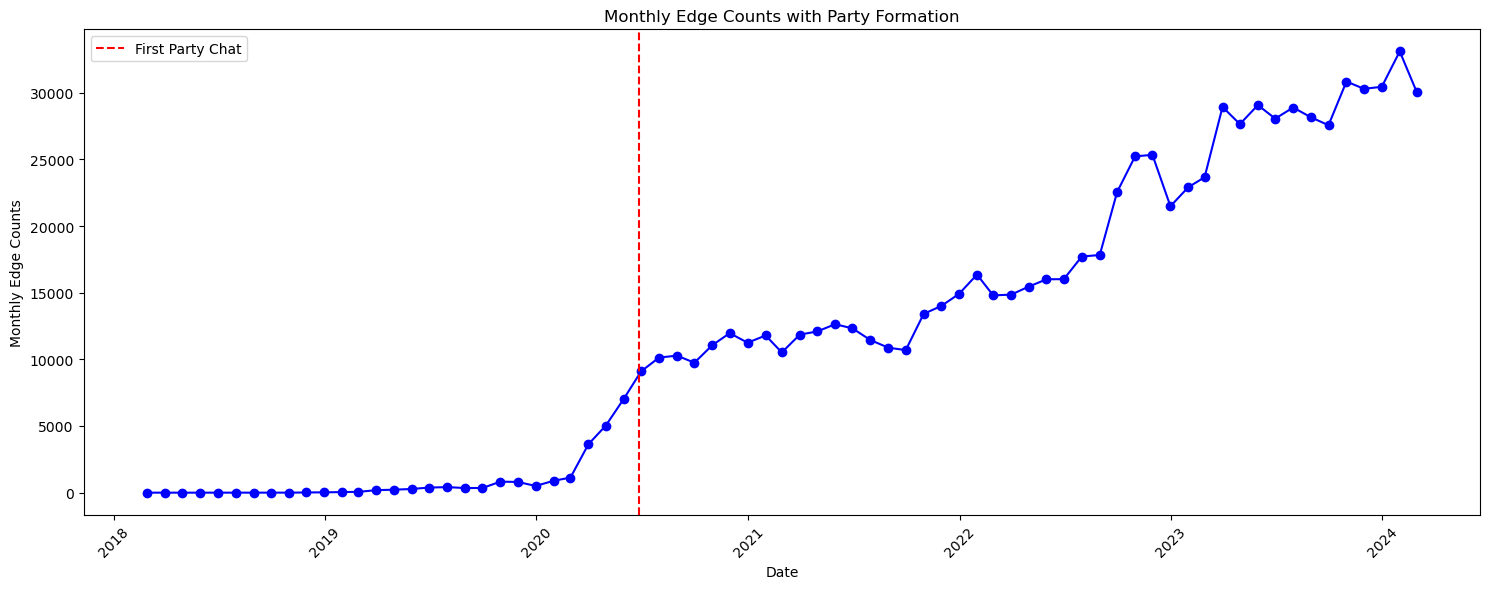

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample Data: Replace with your actual data
monthly_values = [1, 0, 0, 0, 1, 1, 1, 2, 2, 14, 23, 44, 62, 188, 222, 277, 382, 415, 348, 350, 824, 805, 504, 892, 1130, 3630, 5029, 7029, 9098, 10132, 10278, 9747, 11064, 11963, 11246, 11790, 10518, 11854, 12090, 12633, 12324, 11444, 10873, 10693, 13414, 13994, 14908, 16359, 14797, 14853, 15448, 16003, 16016, 17713, 17824, 22552, 25226, 25338, 21483, 22916, 23656, 28930, 27644, 29069, 28057, 28888, 28148, 27562, 30838, 30294, 30440, 33098, 30089, 1810]

# Remove the last month due to incomplete data
monthly_values = monthly_values[:-1]

# Dates for the x-axis
dates = pd.date_range(start='2018-02-28', periods=len(monthly_values), freq='M')

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(dates, monthly_values, marker='o', linestyle='-', color='blue')
plt.axvline(x=pd.Timestamp('2020-06-26'), color='red', linestyle='--', label='First Party Chat')
plt.title('Monthly Edge Counts with Party Formation')
plt.xlabel('Date')
plt.ylabel('Monthly Edge Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### step 4:  Comparing Networks With and Without Party Chats
Creating two versions of the network—one including party chats and one excluding them—can help isolate the effect of the party on the network.

Network Construction: Construct two networks from your dataset: one network includes all edges (with party chats), and the other excludes edges involving party chats.

Network Comparison: Analyze and compare key network metrics between the two networks. Metrics to consider include:

Network Density: A higher density in the network including party chats could indicate the party contributes significantly to network cohesion.
Clustering Coefficient: Differences in the clustering coefficient can reveal changes in network tightness and community structure with the inclusion of party chats.
Centrality Distribution: Comparing centrality distributions can help identify if the party nodes serve as critical connectors or hubs in the network.
Community Structure: Use community detection algorithms to compare the community structures of the two networks. Significant differences may suggest the party's role in forming or disrupting communication clusters